In [8]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import elephant_experiment_analysis as ea

In [46]:
runs = ea.get_all_expe()
runs

['1629982489#EXPE3', '1629982520#EXPE3', '1629992281#EXPE3']

In [56]:
run = '1629992281#EXPE3'
df = ea.get_expe_results(run)
df

          dataset   pool  k_init  k_refinement  max_epochs  k_neighbors  \
0   breast-cancer  Basic      10             0           0            3   
1   breast-cancer  Basic      10             0           0            5   
2   breast-cancer  Basic      10             0           1            3   
3   breast-cancer  Basic      10             0           1            5   
4   breast-cancer  Basic      10             0           2            3   
..            ...    ...     ...           ...         ...          ...   
91  breast-cancer  Basic     300             0          13            5   
92  breast-cancer  Basic     300             0          14            3   
93  breast-cancer  Basic     300             0          14            5   
94  breast-cancer  Basic     300             0          15            3   
95  breast-cancer  Basic     300             0          15            5   

    n_sampling                                      run_suffix  
0           -1    D$breast-cancer_

,pool,dataset,k_init,k_refinement,max_epochs,k_neighbors,n_sampling,competitor,f1_score,n_replication
0,Basic,breast-cancer,10,0,0,3,-1,scores,0.266667,0
1,Basic,breast-cancer,10,0,0,5,-1,scores,0.000000,0
2,Basic,breast-cancer,10,0,1,3,-1,scores,0.375000,0
3,Basic,breast-cancer,10,0,1,5,-1,scores,0.142857,0
4,Basic,breast-cancer,10,0,2,3,-1,scores,0.142857,0
...,...,...,...,...,...,...,...,...,...,...
91,Basic,breast-cancer,300,0,13,5,-1,scores,NaN,0
92,Basic,breast-cancer,300,0,14,3,-1,scores,NaN,0
93,Basic,breast-cancer,300,0,14,5,-1,scores,NaN,0
94,Basic,breast-cancer,300,0,15,3,-1,scores,NaN,0


In [57]:
df.n_replication.unique()

array([0])

breast-cancer


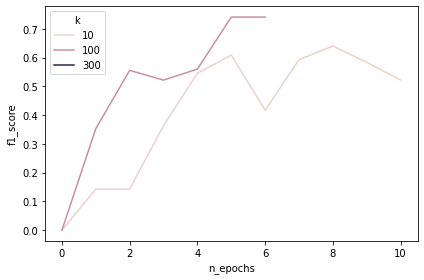

In [58]:
dfas = df.copy()
#dfas = df[df.pool=="AutoGluon"]
#dfas = dfas[dfas.n_replication==4]
dfas = dfas[dfas.k_neighbors==5]
dfas = dfas[dfas.k_init>1]
#dfas = dfas[dfas.dataset=='boston']

#dfas = dfas[dfas.competitor.isin(['P2G-xgb', 'RandomSampling-xgb'])]
#dfas.shape

for d in df.dataset.unique():
    print(d)
    tmp = dfas[dfas.dataset==d]
    
    #tmp = tmp.groupby(['pool','dataset','k_init','k_refinement','max_epochs','n_sampling','competitor']).mean()
    #tmp = tmp.reset_index()
    plt.figure()
    tmp.rename(columns={'k_init':'k', 'max_epochs':'n_epochs'}, inplace=True)

    ax = sns.lineplot(x="n_epochs", y="f1_score", data=tmp, hue="k")
    #sns.scatterplot(x="max_epochs", y="average score", data=tmp)
    #ax.set_ylim((0.0, 1.0))
    #ax.set_title(d)
    
    plt.tight_layout()
    #plt.savefig('../../results/elephant_breastcancer.pdf')
    plt.show()

## Compare with KDE

In [35]:
%%time
import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals
from sklearn.metrics import recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity, KNeighborsClassifier
from discrepancies import pool
import pandas as pd



def run_fidelity_experiment_oneit(dataset, k_init, max_epochs, k_neighbors=1):
    X_train, X_test, y_train, y_test, _, _, _, _ = datasets.get_dataset(dataset=dataset, n_samples=500, noise=0.3)
    pool1 = pool.BasicPool()#max_delta_accuracies=0.05)
    pool1 = pool1.fit(X_train, y_train)
#    print('F1 on Xtest', pool1.predict(X_test).apply(lambda x: f1_score(y_test, x)))
#    print('Discrepancy percentage', pool1.predict_discrepancies(X_train).mean())


    p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=k_init)
    p2g.fit(max_epochs=max_epochs)

    discr_pred = p2g.predict_discrepancies_from_graph(X_test, method='knn', k_neighbors=k_neighbors)
    discr_true = pool1.predict_discrepancies(X_test)
    f1_dig_knn = f1_score(discr_true, discr_pred)
    
    discr_pred = p2g.predict_discrepancies_from_graph(X_test, method='rf', k_neighbors=k_neighbors)
    discr_true = pool1.predict_discrepancies(X_test)
    f1_dig_rf = f1_score(discr_true, discr_pred)
#    print('F1', f1_dig)
    
    n_instances = len(p2g.G.nodes)
    kde = KernelDensity().fit(X_train)
    kde_train = pd.DataFrame(kde.sample(n_samples=n_instances), columns=X_train.columns)
    kde_labels = pool1.predict_discrepancies(kde_train)
    kde_preds_rf = RandomForestClassifier(n_estimators=200).fit(kde_train, kde_labels).predict(X_test)
    kde_preds_knn = KNeighborsClassifier(n_neighbors=k_neighbors).fit(kde_train, kde_labels).predict(X_test)
    f1_kde_knn = f1_score(discr_true, kde_preds_knn)
    f1_kde_rf = f1_score(discr_true, kde_preds_rf)
#    print('F1 KDE %s'%prediction_method, f1_kde)
    return {'f1_dig_knn':f1_dig_knn, 'f1_dig_rf':f1_dig_rf, 'f1_kde_knn': f1_kde_knn, 'f1_kde_rf': f1_kde_rf, 
            'k_init':k_init, 'max_epochs':max_epochs, 'n_instance':n_instances}

def run_fidelity_experiment(n_iteration, dataset, k_init, max_epochs, k_neighbors):
    results = []
    for it in range(n_iteration):
        results.append(run_fidelity_experiment_oneit(dataset, k_init, max_epochs, k_neighbors))
    results = pd.DataFrame(results)
    return results.mean(), results.std()

def run_several_exp(dataset, k_init_list, max_epochs_list, k_neighbors_list):
    for k_init in k_init_list:
        

CPU times: user 72 µs, sys: 355 µs, total: 427 µs
Wall time: 287 µs


In [38]:
DATASET = 'boston'
K_INIT = 100
MAX_EPOCHS= 5
#PREDICTION_METHOD = 'knn' #choose between 'knn' and 'rf'... KNN in paper
K_NEIGHBORS = 3
N_ITERATION = 1


run_fidelity_experiment(N_ITERATION, DATASET, K_INIT, MAX_EPOCHS, K_NEIGHBORS)


[15:42:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


knn
rf!


(f1_dig_knn    0.489796
 f1_dig_rf     0.727273
 f1_kde_knn    0.390244
 f1_kde_rf     0.588235
 dtype: float64,
 f1_dig_knn   NaN
 f1_dig_rf    NaN
 f1_kde_knn   NaN
 f1_kde_rf    NaN
 dtype: float64)